# TP : Détection de DeepFake Audio avec Algorithmes de Machine Learning

## Objectifs
- Comparer différents algorithmes de Machine Learning pour la détection de DeepFake audio
- Extraire des features audio pertinentes (MFCC, spectral features)
- Évaluer les performances avec plusieurs métriques (accuracy, precision, recall, F1-score)
- Visualiser les résultats et comparer les modèles


## 1. Imports et Configuration

Cette section importe toutes les bibliothèques nécessaires pour le projet.


In [2]:
!pip install scikit-learn pydub librosa pandas datasets

  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached audioread-3.1.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached soundfile-0.13.1-py2.py3-none-macosx_11_0_arm64.whl.metadata (16 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-1.0.0-cp312-abi3-macosx_11_0_arm64.whl.metadata (5.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached msgpack-1.1.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.1 kB)
  Using cached standard_aifc-3.13.0-py3-none-any.whl.metadata (969 bytes)
  Using cached standard_sunau-3.13.0-py3-none-any.whl.metadata (914 bytes)
  Using cached standard_chunk-3.13.0-py3-none-any.whl.metadata (860 bytes)
  Using cached audioop_lts-0.2.2-cp313-abi3-macosx_11_0_arm64.whl.metadata (2.0 kB)
Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
Using cached aud

In [3]:
# Gestion des données
from datasets import load_dataset
import pandas as pd
import numpy as np
import os
import random

# Traitement audio
import librosa
from pydub import AudioSegment

# Progress bar
from tqdm import tqdm

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Style pour les graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## 2. Fonctions Utilitaires

Cette section définit les fonctions nécessaires pour le traitement des données audio.


In [4]:
def save_audio(file: str, wav_bytes):
    """
    Sauvegarde des données audio binaires dans un fichier.
    
    Args:
        file: Chemin du fichier de destination
        wav_bytes: Données audio au format bytes
    """
    os.makedirs(os.path.dirname(file), exist_ok=True)
    with open(file, "wb") as f:
        f.write(wav_bytes)

def convert_mp3_to_wav(file: str):
    """
    Convertit un fichier MP3 en format WAV.
    
    Args:
        file: Chemin du fichier MP3 à convertir
    """
    sound = AudioSegment.from_mp3(file)
    wav_file = file.replace(".mp3", ".wav")
    sound.export(wav_file, format="wav")
    return wav_file


## 3. Extraction de Features Audio

Cette section définit la fonction d'extraction de features. Nous utilisons plusieurs types de features pour améliorer la performance:
- **MFCC (Mel-Frequency Cepstral Coefficients)**: Features standards pour la reconnaissance vocale
- **Features spectrales**: Zero crossing rate, spectral centroid, spectral rolloff
- **Chroma**: Caractéristiques harmoniques et tonales


In [16]:
def extract_features(file_path: str, n_mfcc: int = 13):
    """
    Extrait des features audio complètes d'un fichier audio.
    
    Args:
        file_path: Chemin vers le fichier audio
        n_mfcc: Nombre de coefficients MFCC à extraire (défaut: 13)
    
    Returns:
        numpy.array: Vecteur de features extraites
    """
    try:
        # Chargement de l'audio
        audio, sample_rate = librosa.load(file_path, sr=None)
        
        # Features MFCC (Mel-Frequency Cepstral Coefficients)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfccs_mean = np.mean(mfccs.T, axis=0).flatten()
        mfccs_std = np.std(mfccs.T, axis=0).flatten()
        
        # Features spectrales
        spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)[0]
        zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]
        
        # Features chromatiques (harmoniques)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_mean = np.mean(chroma.T, axis=0).flatten()
        
        # Tempo (estimation) - s'assurer que c'est un scalaire
        tempo, _ = librosa.beat.beat_track(y=audio, sr=sample_rate)
        if isinstance(tempo, np.ndarray):
            tempo = float(tempo[0]) if len(tempo) > 0 else 0.0
        else:
            tempo = float(tempo)
        
        # Combinaison de toutes les features - toutes doivent être 1D
        features = np.concatenate([
            mfccs_mean,  # 13 features
            mfccs_std,   # 13 features
            np.array([float(np.mean(spectral_centroids))]),  # 1 feature
            np.array([float(np.std(spectral_centroids))]),   # 1 feature
            np.array([float(np.mean(spectral_rolloff))]),    # 1 feature
            np.array([float(np.std(spectral_rolloff))]),     # 1 feature
            np.array([float(np.mean(zero_crossing_rate))]),  # 1 feature
            np.array([float(np.std(zero_crossing_rate))]),   # 1 feature
            chroma_mean,  # 12 features
            np.array([tempo])       # 1 feature
        ])
        
        return features.flatten()
    
    except Exception as e:
        print(f"Erreur lors de l'extraction des features de {file_path}: {e}")
        # Retourne un vecteur de zéros en cas d'erreur
        return np.zeros(13 * 2 + 1 + 1 + 1 + 1 + 1 + 1 + 12 + 1)


## 4. Chargement et Préparation des Données

### 4.1. Chargement du Dataset

Nous utilisons le dataset "WpythonW/real-fake-voices-dataset" depuis Hugging Face.


In [6]:
# Chargement du dataset
print("Chargement du dataset...")
ds = load_dataset("WpythonW/real-fake-voices-dataset", split="train")
df = ds.to_pandas()
print(f"Dataset chargé: {len(df)} échantillons")
print(f"Colonnes: {df.columns.tolist()}")
df.head()


Chargement du dataset...


README.md:   0%|          | 0.00/684 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/325M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/320M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/158M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1954 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/489 [00:00<?, ? examples/s]

Dataset chargé: 1954 échantillons
Colonnes: ['audio_path', 'sentence', 'gender', 'locale', 'age', 'authenticity', 'characteristic']


,audio_path,sentence,gender,locale,age,authenticity,characteristic
0,{'bytes': b'RIFF$\x8c\n\x00WAVEfmt \x10\x00\x0...,本条目将解说原作漫画与其他多数的传播作品。,female,zh-CN,twenties,real,
1,{'bytes': b'RIFF$\xec\x04\x00WAVEfmt \x10\x00\...,Couple of hours after.,female,en,twenties,real,
2,{'bytes': b'RIFF$\x06\x0c\x00WAVEfmt \x10\x00\...,演员模型的指称语义是演员的指称域理论的研究主题。,female,zh-CN,twenties,real,
3,{'bytes': b'\xff\xfbP\xc4\x00\x03\x89\x10\\\xf...,,,,,fake,voice_preview_posie - young and inquisitive
4,{'bytes': b'RIFF$\xb2\x05\x00WAVEfmt \x10\x00\...,コピー機使ってるとき、待ってる人いると焦る,male,ja,twenties,real,


### 4.2. Sauvegarde des Fichiers Audio

Les fichiers audio sont sauvegardés dans des dossiers séparés selon leur authenticité (Real/Fake).


In [13]:
# Sauvegarde des fichiers audio
print("Sauvegarde des fichiers audio...")

def convert_mp3_to_wav(file):
    sound = AudioSegment.from_mp3(file)
    sound.export(file.replace(".mp3", ".wav"), format="wav")
    
for idx, row in tqdm(df.iterrows(), total=len(df)):
    subfol = "Real" if row["authenticity"] == "real" else "Fake"
    file = f"./Audio/Train/{subfol}/{row['audio_path']['path']}"
    save_audio(file, row["audio_path"]["bytes"])
    try:
        convert_mp3_to_wav(file)
    except Exception:
        pass


Sauvegarde des fichiers audio...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1954/1954 [02:29<00:00, 13.05it/s]


### 4.3. Préparation des Chemins de Fichiers

Nous préparons les listes de fichiers audio pour l'extraction de features.


In [14]:
# Chemins des dossiers audio
real_audio_path = './Audio/Train/Real/'
fake_audio_path = './Audio/Train/Fake/'

# Liste des fichiers WAV
real_audio_files = [os.path.join(real_audio_path, file) 
                   for file in os.listdir(real_audio_path) 
                   if file.endswith('.wav')]
fake_audio_files = [os.path.join(fake_audio_path, file) 
                   for file in os.listdir(fake_audio_path) 
                   if file.endswith('.wav')]

# Équilibrer les classes (si nécessaire)
min_samples = min(len(real_audio_files), len(fake_audio_files))
if len(real_audio_files) > min_samples:
    real_audio_files = random.sample(real_audio_files, min_samples)
if len(fake_audio_files) > min_samples:
    fake_audio_files = random.sample(fake_audio_files, min_samples)

print(f"Fichiers Real: {len(real_audio_files)}")
print(f"Fichiers Fake: {len(fake_audio_files)}")
print(f"Total: {len(real_audio_files) + len(fake_audio_files)} fichiers")


Fichiers Real: 754
Fichiers Fake: 754
Total: 1508 fichiers


### 4.4. Extraction des Features

Extraction des features pour tous les fichiers audio. Cette étape peut prendre plusieurs minutes.


In [17]:
# Extraction des features
print("Extraction des features audio...")
X = []
y = []

# Features pour les fichiers Real (label 0)
for file in tqdm(real_audio_files, desc="Traitement Real"):
    features = extract_features(file)
    X.append(features)
    y.append(0)  # Label 0 pour Real

# Features pour les fichiers Fake (label 1)
for file in tqdm(fake_audio_files, desc="Traitement Fake"):
    features = extract_features(file)
    X.append(features)
    y.append(1)  # Label 1 pour Fake

# Conversion en numpy arrays
X = np.array(X)
y = np.array(y)

print(f"\nShape des features: {X.shape}")
print(f"Nombre de features par échantillon: {X.shape[1]}")
print(f"Distribution des classes: {np.bincount(y)}")


Extraction des features audio...


Traitement Fake:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 483/754 [00:23<00:12, 20.85it/s]/Users/euraste.djire/Documents/Python/venv/default/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1152
  warnings.warn(
/Users/euraste.djire/Documents/Python/venv/default/lib/python3.13/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Traitement Fake: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 754/754 [00:35<00:00, 21.11it/s]


Shape des features: (1508, 45)
Nombre de features par échantillon: 45
Distribution des classes: [754 754]


### 4.5. Normalisation et Division Train/Test

Normalisation des features et division en ensembles d'entraînement et de test (80/20).


In [18]:
# Division train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Normalisation des features (important pour certains algorithmes)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape[0]} échantillons")
print(f"Test set: {X_test.shape[0]} échantillons")
print(f"Nombre de features: {X_train.shape[1]}")


Train set: 1206 échantillons
Test set: 302 échantillons
Nombre de features: 45


## 5. Modèles de Machine Learning

Nous allons tester plusieurs algorithmes de classification:

1. **Random Forest**: Ensemble d'arbres de décision
2. **Support Vector Machine (SVM)**: Machine à vecteurs de support
3. **Logistic Regression**: Régression logistique
4. **Gradient Boosting**: Boosting avec descente de gradient
5. **Multi-Layer Perceptron (MLP)**: Réseau de neurones
6. **XGBoost**: Gradient boosting optimisé (si disponible)


In [21]:
# Définition des modèles
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'SVM': SVC(
        kernel='rbf', 
        probability=True,  # Nécessaire pour ROC curve
        random_state=RANDOM_STATE
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

print(f"Modèles à tester: {list(models.keys())}")


Modèles à tester: ['Random Forest', 'SVM', 'Logistic Regression']


## 6. Entraînement et Évaluation des Modèles

Chaque modèle est entraîné et évalué avec plusieurs métriques.


In [22]:
# Dictionnaire pour stocker les résultats
results = {}
predictions = {}
probabilities = {}

# Entraînement et évaluation de chaque modèle
for name, model in tqdm(models.items(), desc="Entraînement des modèles"):
    print(f"\n{'='*60}")
    print(f"Entraînement: {name}")
    print(f"{'='*60}")
    
    # Utiliser les données normalisées pour SVM, LR et MLP
    if name in ['SVM', 'Logistic Regression', 'MLP (Neural Network)']:
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
    else:
        X_train_used = X_train
        X_test_used = X_test
    
    # Entraînement
    model.fit(X_train_used, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test_used)
    
    # Probabilités (pour ROC curve)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_used)[:, 1]
    else:
        y_proba = None
    
    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # AUC-ROC (si probabilités disponibles)
    auc_score = None
    if y_proba is not None:
        auc_score = roc_auc_score(y_test, y_proba)
    
    # Stockage des résultats
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_score
    }
    
    predictions[name] = y_pred
    probabilities[name] = y_proba
    
    # Affichage des résultats
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if auc_score:
        print(f"AUC-ROC:   {auc_score:.4f}")
    
    # Rapport détaillé
    print(f"\nRapport de classification:\n")
    print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))


Entraînement des modèles:  33%|████████████████████████████████████████████████████████████████▎                                                                                                                                | 1/3 [00:00<00:00,  6.56it/s]


Entraînement: Random Forest
Accuracy:  0.9106
Precision: 0.9306
Recall:    0.8874
F1-Score:  0.9085
AUC-ROC:   0.9640

Rapport de classification:

              precision    recall  f1-score   support

        Real       0.89      0.93      0.91       151
        Fake       0.93      0.89      0.91       151

    accuracy                           0.91       302
   macro avg       0.91      0.91      0.91       302
weighted avg       0.91      0.91      0.91       302


Entraînement: SVM


Entraînement des modèles:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2/3 [00:00<00:00,  8.18it/s]

Accuracy:  0.9371
Precision: 0.9648
Recall:    0.9073
F1-Score:  0.9352
AUC-ROC:   0.9836

Rapport de classification:

              precision    recall  f1-score   support

        Real       0.91      0.97      0.94       151
        Fake       0.96      0.91      0.94       151

    accuracy                           0.94       302
   macro avg       0.94      0.94      0.94       302
weighted avg       0.94      0.94      0.94       302


Entraînement: Logistic Regression


Entraînement des modèles: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]

Accuracy:  0.9172
Precision: 0.9257
Recall:    0.9073
F1-Score:  0.9164
AUC-ROC:   0.9667

Rapport de classification:

              precision    recall  f1-score   support

        Real       0.91      0.93      0.92       151
        Fake       0.93      0.91      0.92       151

    accuracy                           0.92       302
   macro avg       0.92      0.92      0.92       302
weighted avg       0.92      0.92      0.92       302



## 7. Comparaison des Modèles

### 7.1. Tableau Comparatif



COMPARAISON DES MODÈLES
                     accuracy  precision    recall  f1_score   auc_roc
SVM                  0.937086   0.964789  0.907285  0.935154  0.983553
Logistic Regression  0.917219   0.925676  0.907285  0.916388  0.966712
Random Forest        0.910596   0.930556  0.887417  0.908475  0.964015


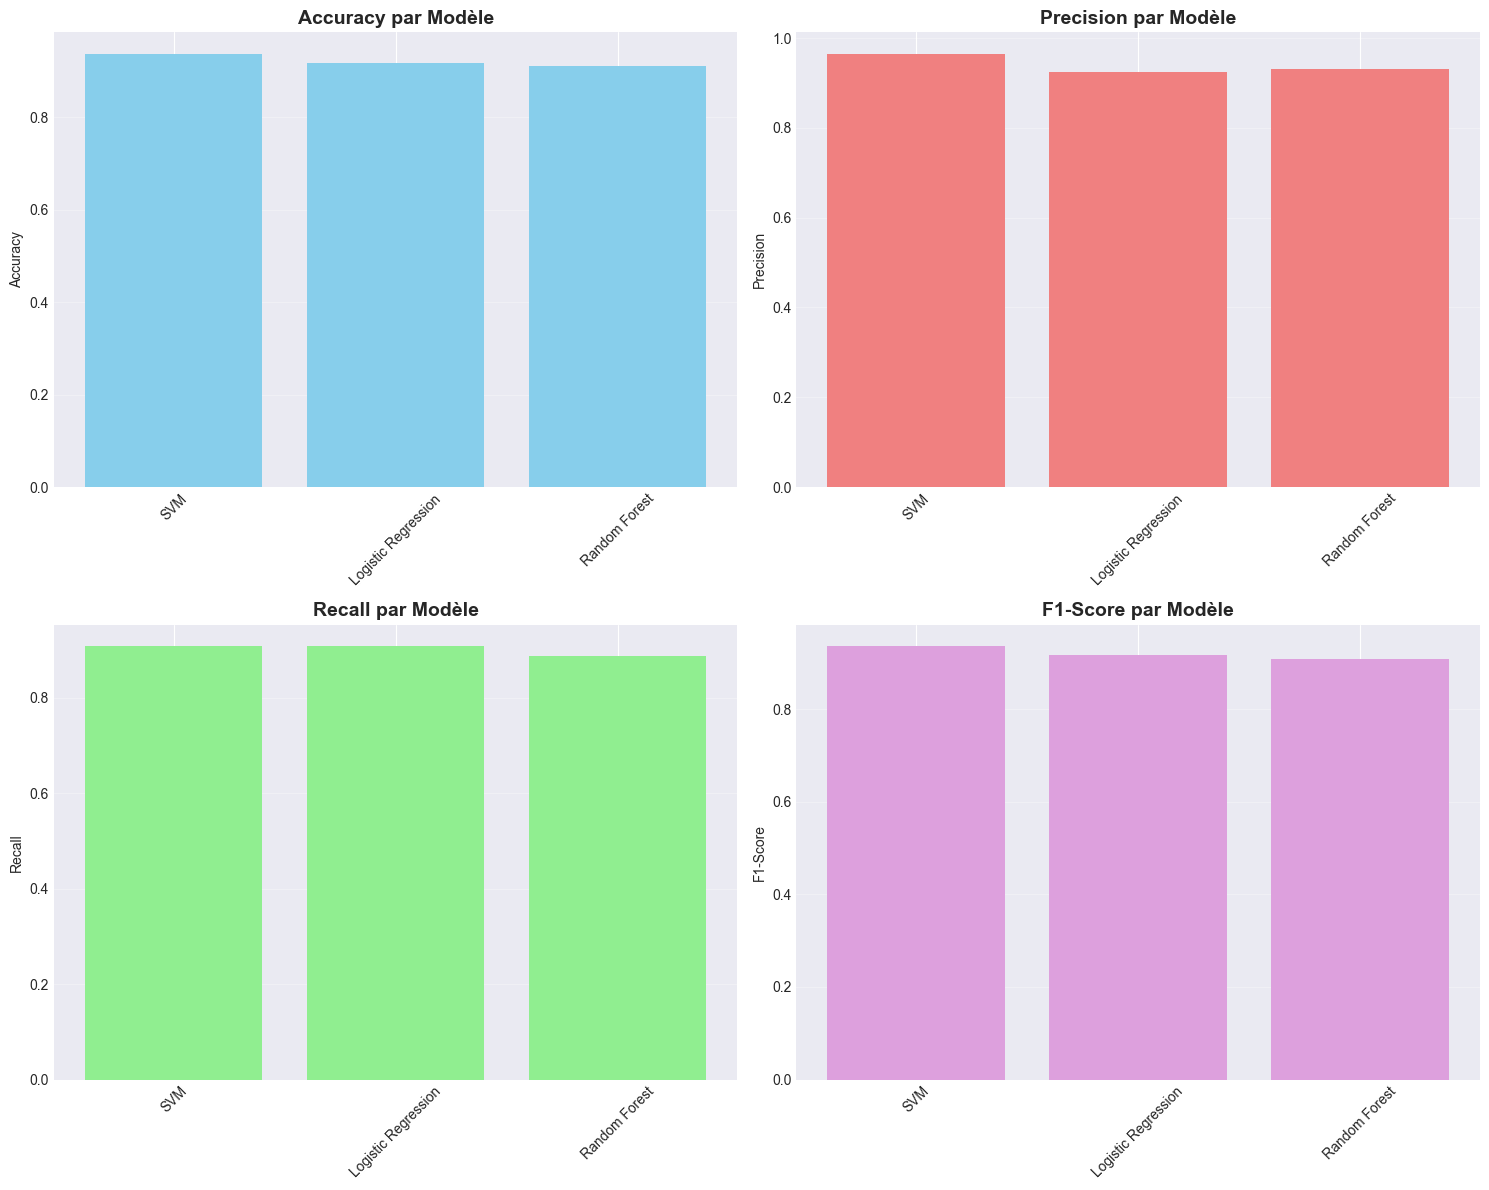

In [23]:
# Création d'un DataFrame pour la comparaison
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('accuracy', ascending=False)

print("\n" + "="*70)
print("COMPARAISON DES MODÈLES")
print("="*70)
print(comparison_df.to_string())

# Affichage graphique
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy
axes[0, 0].bar(comparison_df.index, comparison_df['accuracy'], color='skyblue')
axes[0, 0].set_title('Accuracy par Modèle', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Precision
axes[0, 1].bar(comparison_df.index, comparison_df['precision'], color='lightcoral')
axes[0, 1].set_title('Precision par Modèle', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Recall
axes[1, 0].bar(comparison_df.index, comparison_df['recall'], color='lightgreen')
axes[1, 0].set_title('Recall par Modèle', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# F1-Score
axes[1, 1].bar(comparison_df.index, comparison_df['f1_score'], color='plum')
axes[1, 1].set_title('F1-Score par Modèle', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### 7.2. Matrices de Confusion

Visualisation des matrices de confusion pour chaque modèle.


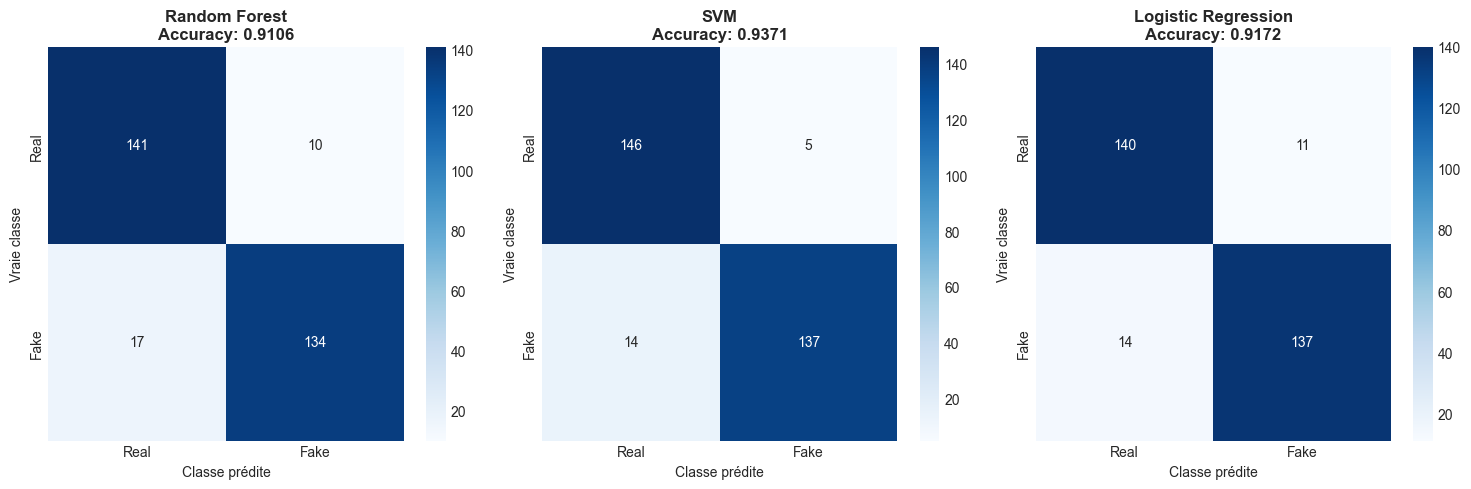

In [24]:
# Calcul du nombre de lignes et colonnes pour la grille
n_models = len(models)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        ax=axes[idx],
        xticklabels=['Real', 'Fake'],
        yticklabels=['Real', 'Fake']
    )
    
    axes[idx].set_title(f'{name}\nAccuracy: {results[name]["accuracy"]:.4f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Vraie classe')
    axes[idx].set_xlabel('Classe prédite')

# Masquer les axes inutilisés
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


### 7.3. Courbes ROC

Comparaison des courbes ROC (Receiver Operating Characteristic) pour tous les modèles.


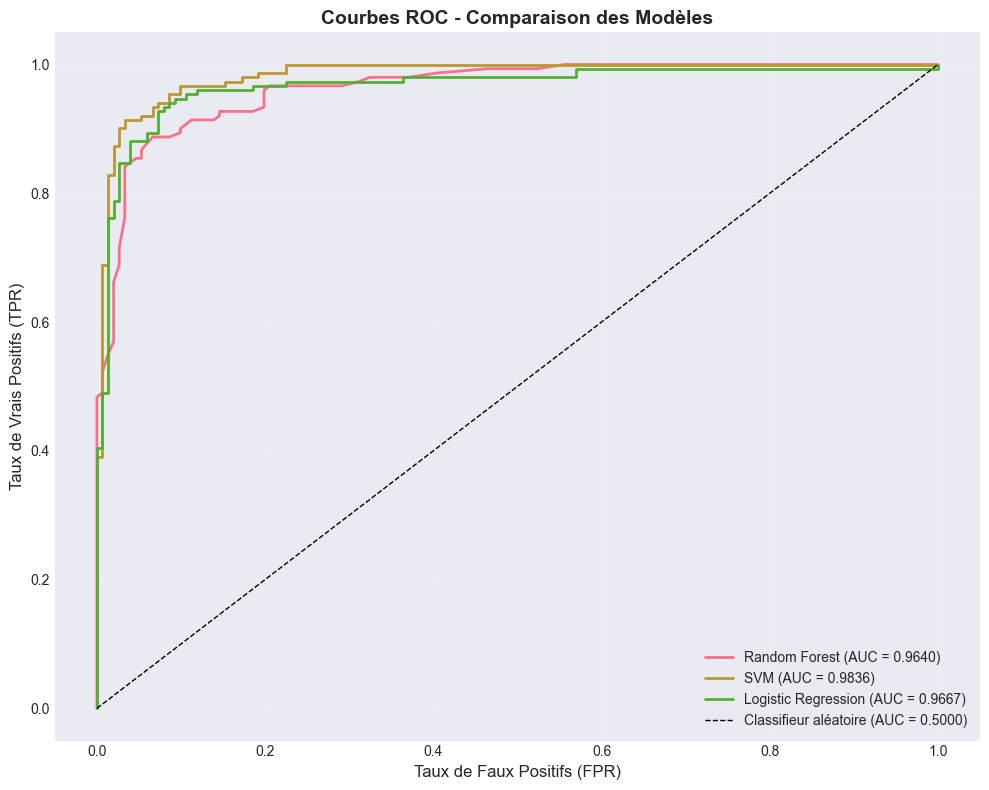

In [25]:
plt.figure(figsize=(10, 8))

for name, y_proba in probabilities.items():
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = results[name]['auc_roc']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', linewidth=2)

# Ligne diagonale (classifieur aléatoire)
plt.plot([0, 1], [0, 1], 'k--', label='Classifieur aléatoire (AUC = 0.5000)', linewidth=1)

plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbes ROC - Comparaison des Modèles', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Analyse de l'Importance des Features

Analyse de l'importance des features pour le meilleur modèle (Random Forest).


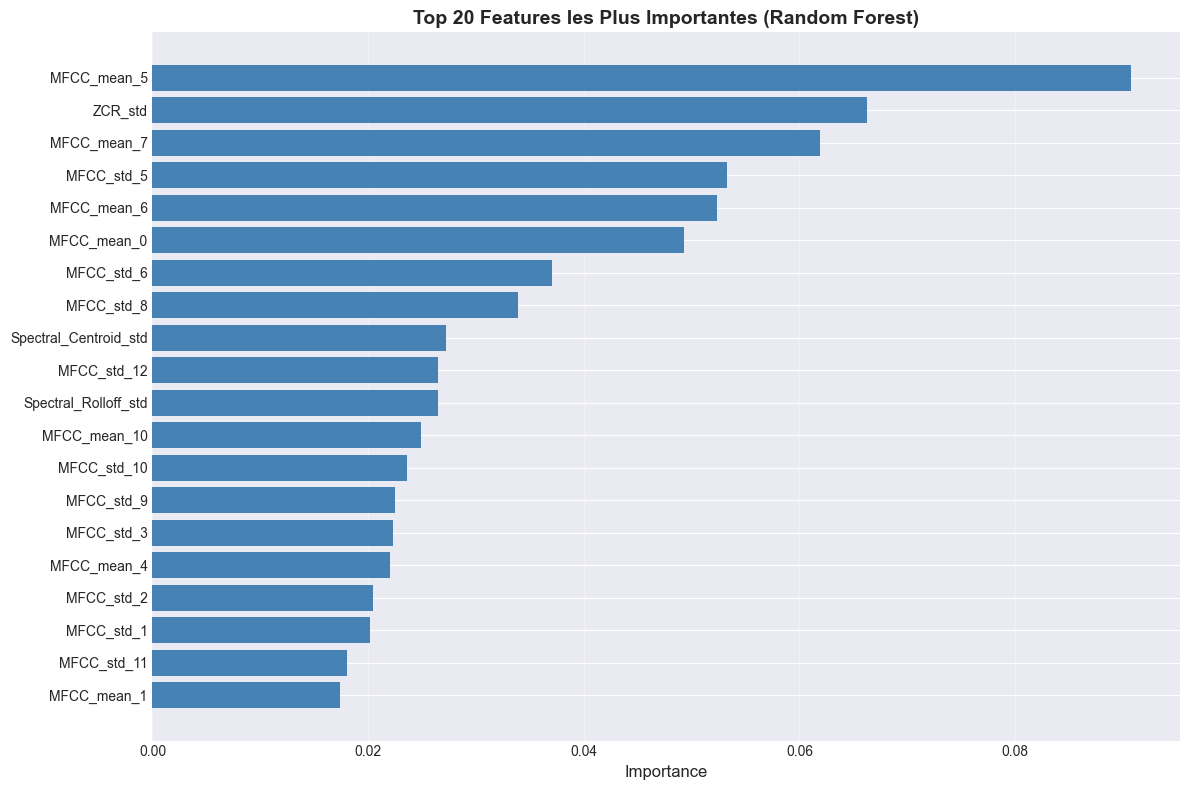


Top 10 Features les Plus Importantes:
1. MFCC_mean_5: 0.0908
2. ZCR_std: 0.0662
3. MFCC_mean_7: 0.0619
4. MFCC_std_5: 0.0532
5. MFCC_mean_6: 0.0524
6. MFCC_mean_0: 0.0493
7. MFCC_std_6: 0.0371
8. MFCC_std_8: 0.0339
9. Spectral_Centroid_std: 0.0272
10. MFCC_std_12: 0.0265


In [26]:
# Importance des features pour Random Forest
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    feature_importance = rf_model.feature_importances_
    
    # Création des noms de features
    feature_names = (
        [f'MFCC_mean_{i}' for i in range(13)] +
        [f'MFCC_std_{i}' for i in range(13)] +
        ['Spectral_Centroid_mean', 'Spectral_Centroid_std'] +
        ['Spectral_Rolloff_mean', 'Spectral_Rolloff_std'] +
        ['ZCR_mean', 'ZCR_std'] +
        [f'Chroma_{i}' for i in range(12)] +
        ['Tempo']
    )
    
    # Tri par importance
    indices = np.argsort(feature_importance)[::-1]
    
    # Affichage des 20 features les plus importantes
    plt.figure(figsize=(12, 8))
    top_n = min(20, len(feature_names))
    plt.barh(range(top_n), feature_importance[indices[:top_n]], color='steelblue')
    plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top {top_n} Features les Plus Importantes (Random Forest)', 
             fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Features les Plus Importantes:")
    for i in range(min(10, len(feature_names))):
        idx = indices[i]
        print(f"{i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")
